 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

Скачаем обучающую и контрольную выборки.

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

In [3]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2048,
                                          shuffle=True, num_workers=14)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=2048,
                                         shuffle=False, num_workers=14)

classes = trainset.classes

Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

## Обработка и исследование входныхданных

In [4]:
print(f'train: {len(trainset)}, test: {len(testset)}')

train: 60000, test: 10000


In [5]:
train_unique =  trainset.targets.unique(return_counts=True)[1]
test_unique = testset.targets.unique(return_counts=True)[1]
is_uni_train = (torch.mean(test_unique[0].float()) == test_unique[0]).item()
is_uni_test = (torch.mean(train_unique[0].float()) == train_unique[0]).item()

In [6]:
print(f'Train {"is" if is_uni_train else "is not"} uniform distrubuted')
print(f'Test {"is" if is_uni_test else "is not"} uniform distrubuted')

Train is uniform distrubuted
Test is uniform distrubuted


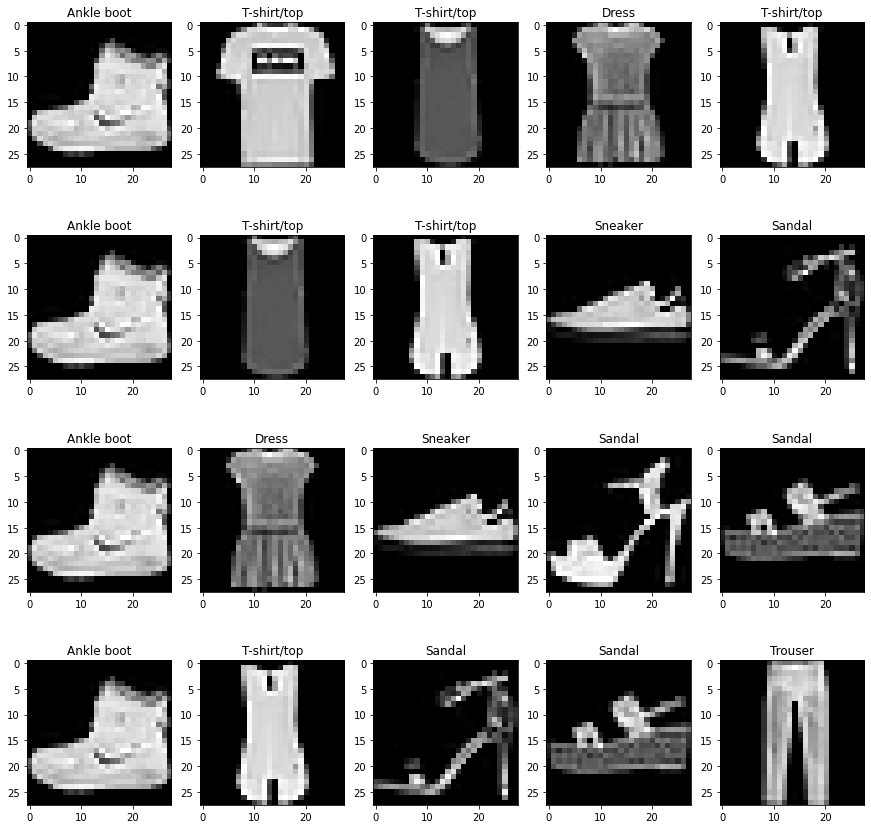

In [7]:
rows, columns = 4, 5
figure, axis = plt.subplots(rows, columns, figsize=(15, 15))
for i in range(rows):
    for j in range(columns):
        axis[i, j].imshow(trainset.data[i * j + j], cmap='gray')
        axis[i, j].set_title(classes[trainset.targets[i * j + j].item()])
    
    

## Построение и тестирование моделей

In [8]:
from torch.optim import Adam
from tqdm.auto import trange, tqdm
import torch.nn as nn
import torch.nn.functional as F
import sys
import seaborn as sns
from torchmetrics import Accuracy

torch.manual_seed(42);

In [9]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
if device == 'cuda:0':
    !nvidia-smi

Sat Dec  3 19:54:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.06       Driver Version: 522.06       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P0    32W /  N/A |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
def train(model, epochs, optim, loss_fn):
    erange = trange(epochs)

    model.to(device)

    loss_dict = {
        'train' : [],
        'test' : []
        }

    accuracy_dict = {
        'train' : [],
        'test' : []
    }


    best_params = None
    best_ep = None
    best_accuracy = 0
    accuracy = Accuracy(task="multiclass", num_classes=10)

    for i in erange:
        for stage in ['train', 'test']:
            running_loss = 0.0
            running_accuracy = 0.0
            runs = 0
            if stage == 'train':
                loader = trainloader
                model.train()
            else:
                loader = testloader
                model.eval()
            
            for batch_X, batch_Y in loader:
                batch_X = batch_X.to(device)
                batch_Y = batch_Y.to(device)
                
                if stage == 'train':
                    model.zero_grad()
                    out = model(batch_X)
                    loss = loss_fn(out, batch_Y.view(-1))
                    loss.backward()
                    optim.step()
                else:
                    with torch.no_grad():
                        out = model(batch_X)
                        loss = loss_fn(out, batch_Y.view(-1))
                        
                accuracy_metric = accuracy(out.cpu(), batch_Y.cpu())

                running_loss += loss.item()
                running_accuracy += accuracy_metric.item()
                runs += 1
                
            epoch_loss = running_loss/runs
            epoch_accuracy = running_accuracy/runs
            
            loss_dict[stage].append(epoch_loss)
            accuracy_dict[stage].append(epoch_accuracy)
                
            if stage == 'test' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_params = model.state_dict()
                best_ep = i
                
        erange.desc = f'Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}'

    model.load_state_dict(best_params)
    return model, loss_dict, accuracy_dict, best_ep, best_accuracy

In [11]:
def plot(loss_dict, accuracy_dict):
    fig, axs = plt.subplots(ncols=2, figsize=(20, 6))
    sns.lineplot(accuracy_dict, ax=axs[0])
    axs[0].set_title('Accuracy')
    sns.lineplot(loss_dict, ax=axs[1])
    axs[1].set_title('Loss')
    

In [22]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

### MLP

In [12]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.__fc1 = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        # self.__fc2 = nn.Sequential(
        #     nn.Linear(512, 512),
        #     nn.ReLU(),
        #     nn.Dropout(0.2)
        # )
        self.__fc3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.__fc4 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.__fc5 = nn.Sequential(
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.__fc1(x)
        # x = self.__fc2(x)
        x = self.__fc3(x)
        x = self.__fc4(x)
        x = self.__fc5(x)
        return x

In [13]:
model = MLP()

optim = Adam(params=model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [14]:
model, loss_dict, accuracy_dict, best_ep, best_accuracy = train(model, 100, optim, loss_fn)
print(f'Best epoch: {best_ep}, best accuracy: {best_accuracy:.4f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Best epoch: 80, best accuracy: 0.9053


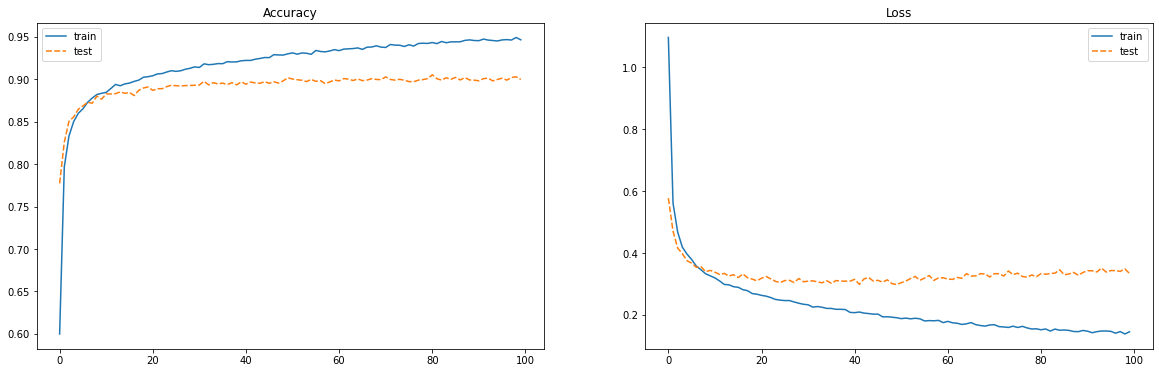

In [15]:
plot(loss_dict, accuracy_dict)

In [16]:
model.cpu()
torch.save(model.state_dict(), f'pretrained/MLP{best_accuracy:.2f}.pth')

Можно было бы еще поиграться с колличеством слоев, их размерностями, dropout и batch-norm, но, как мне кажется, 0.89 accuracy - достаточен для такой архитектуры

## CNN

In [38]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.__conv = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2),
        )

        self.__dense = nn.Sequential(
            nn.Linear(64 * 5 * 5, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.__conv(x)
        x = x.view(-1, 64 * 5 * 5)
        x = self.__dense(x)
        return x

In [39]:
model = CNN()

optim = Adam(params=model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [40]:
model, loss_dict, accuracy_dict, best_ep, best_accuracy = train(model, 100, optim, loss_fn)
print(f'Best epoch: {best_ep}, best accuracy: {best_accuracy:.4f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Best epoch: 93, best accuracy: 0.9252


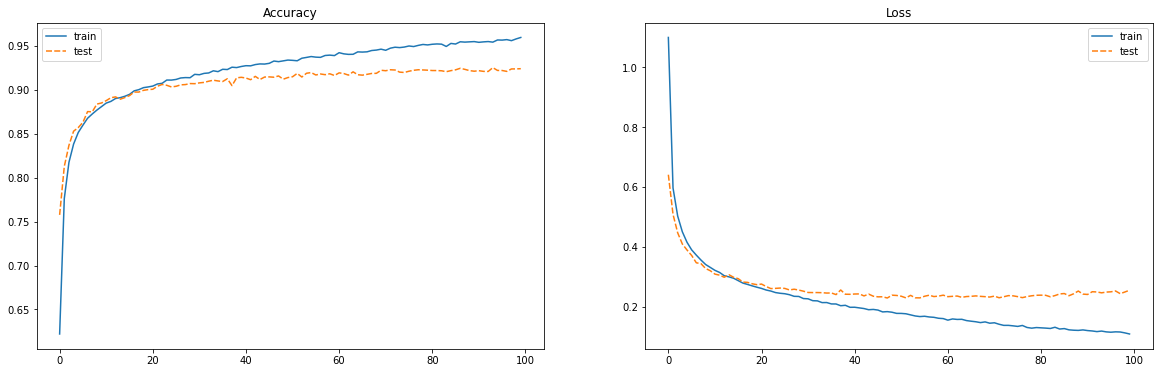

In [41]:
plot(loss_dict, accuracy_dict)

In [34]:
model.cpu()
torch.save(model.state_dict(), f'pretrained/CNN{best_accuracy:.2f}.pth')

### Вывод

CNN показала точность выше, практически на 2%, при этом имея практически в 3 раза меньше параметров: 567434 против 225034. Также loss немного меньше. В обоих случаях test loss со временем начинает расти, что может говорить о переобучении. Это можно попробовать исправить, увеличив dropout(не факт, что получится что-то хорошее получить в MLP, так как там и так используется p=0.4, но я пробовал p=0.4 на CNN и там получалось лучше, но сходимось замедлялась слишком сильно)

In [23]:
get_n_params(CNN())

225034

In [24]:
get_n_params(MLP())

567434